In [44]:
import os
import sys
newPath = os.path.dirname(os.path.abspath(""))
if newPath not in sys.path:
    sys.path.append(newPath)
from BI import bi
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS
from numpyro import handlers
from jax import random, vmap


m = bi(platform='cpu')

jax.local_device_count 16


# Linear relationships

jax.local_device_count 16


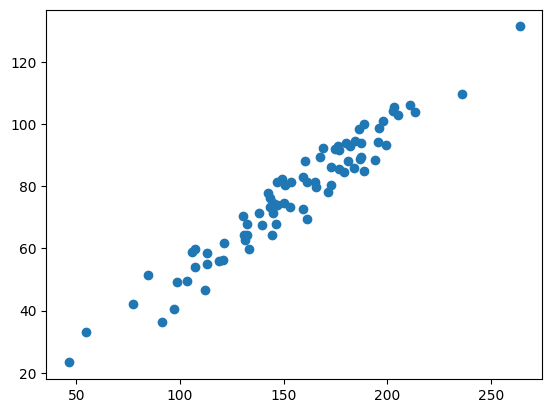

In [45]:
# setup platform------------------------------------------------
m = bi(platform='cpu')
alpha= 0.6
beta = 0.5
sigma= 5
x=m.dist.normal(160, 40,sample=True,shape=(100,))
lk=alpha+beta*x
y=m.dist.normal(lk, sigma,sample=True,seed=2)
data=jnp.array([x,y]).T

def split_train_test(arr):
    # Get the length of the array
    n = arr.shape[0]
    
    # Calculate the split index (80% for training)
    train_idx = int(n * 0.8)
    
    # Generate a random permutation of indices
    key = jax.random.PRNGKey(0)  # You can use a fixed key for reproducibility
    permuted_indices = jax.random.permutation(key, n)
    
    # Split the permuted indices
    train_indices = permuted_indices[:train_idx]
    test_indices = permuted_indices[train_idx:]
    
    # Split the original array based on the indices
    train_set = arr[train_indices]
    test_set = arr[test_indices]
    
    return train_set, test_set

train, test = split_train_test(data)

dataTrain= dict(X=train[:,0].reshape((train[:,0].shape[0],1)),Y=train[:,1].reshape((train[:,0].shape[0],1)))

m.data_on_model=dataTrain

plt.scatter(dataTrain['X'], dataTrain['Y'])

## Scaling data as activation function (tanh) concider values between -1 and 1.

In [46]:
X_mean = jnp.mean(dataTrain['X'], axis=0)
X_std = jnp.std(dataTrain['X'], axis=0)
Y_mean = jnp.mean(dataTrain['Y'], axis=0)
Y_std = jnp.std(dataTrain['Y'], axis=0)
X=(dataTrain['X'] - X_mean) / X_std
Y=(dataTrain['Y'] - Y_mean) / Y_std
m.data_on_model= dict(X=X, Y=Y)

## Model

In [47]:
def model(X, Y,  D_H=5, D_Y=1):  
    N, D_X = X.shape
    
    # First hidden layer: Transforms input to N × D_H (hidden units)
    w1 = m.bnn.layer_linear(
        X=X, 
        dist=m.dist.normal(0, 1,  name='w1',shape=(D_X,D_H)),
        activation='tanh'
        )

    # sample final layer of weights and neural network output
    # Final layer (z3) computes linear combination of second hidden layer
    w2 = m.bnn.layer_linear(
        X=w1, 
        dist=m.dist.normal(0, 1,  name='w2',shape=(D_H,D_Y))
        )


    s = m.dist.exponential(1, name='s')

    m.dist.normal(w2, s, obs=Y,name='Y')

m.fit(model, num_samples=500) 

sample: 100%|██████████| 1000/1000 [00:09<00:00, 106.55it/s, 127 steps of size 1.42e-02. acc. prob=0.94]


### Model



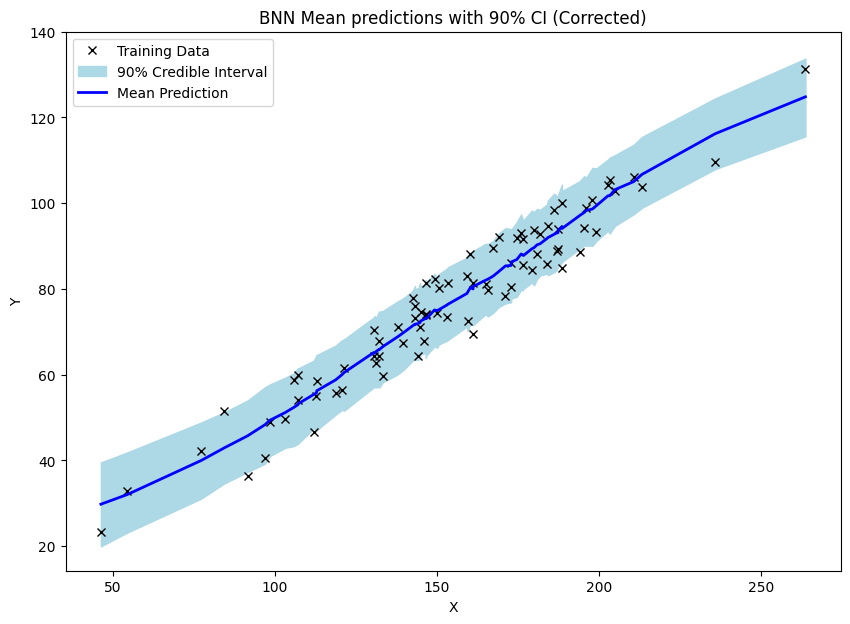

In [59]:
# --- CORRECTED PLOTTING CODE ---
pred_standardized = m.sample(samples = 500)['Y']
# Calculate statistics on the standardized predictions
mean_pred_std = jnp.mean(pred_standardized, axis=0).squeeze()
percentiles_std = np.percentile(pred_standardized, [5.0, 95.0], axis=0).squeeze()


# --- 2. De-standardize Predictions ---
# This is the critical step. We use the mean and std deviation from the 
# ORIGINAL training data (Y_mean, Y_std) to scale the predictions back.
mean_pred_orig = (mean_pred_std * Y_std) + Y_mean
percentiles_orig = (percentiles_std * Y_std) + Y_mean


# --- 3. Prepare Data for Plotting ---
# For a clean line plot, it's essential to sort the X values.
# We must apply the same sorting order to our predictions and percentiles.
X_orig = dataTrain['X'].squeeze()
Y_orig = dataTrain['Y'].squeeze()

sort_indices = jnp.argsort(X_orig)

X_plot = X_orig[sort_indices]
Y_plot = Y_orig[sort_indices]
mean_pred_plot = mean_pred_orig[sort_indices]
percentiles_plot = percentiles_orig[:, sort_indices]


# --- 4. Plotting on Original Scale ---
# Now, we use the original data and the de-standardized predictions.
fig, ax = plt.subplots(figsize=(10, 7))

# Plot original training data
ax.plot(X_plot, Y_plot, 'kx', label='Training Data')

# Plot the 90% Credible Interval (de-standardized)
ax.fill_between(
    X_plot,
    percentiles_plot[0, :],
    percentiles_plot[1, :],
    color='lightblue',
    label='90% Credible Interval'
)

# Plot the mean prediction (de-standardized)
ax.plot(X_plot, mean_pred_plot, 'b-', lw=2, label='Mean Prediction')

# Set labels, title, and legend
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_title("BNN Mean predictions with 90% CI (Corrected)")
ax.legend()
ax.set_ylim(top=140) # Set y-limit to match example image

plt.show()

# Non linear relationships

In [41]:
def get_data(N=50, D_X=1, sigma_obs=0.05, N_test=500):
    D_Y = 1  # create 1d outputs
    np.random.seed(0)
    X = jnp.linspace(-1, 1, N)
    X = jnp.power(X[:, np.newaxis], jnp.arange(D_X))
    W = 0.5 * np.random.randn(D_X)
    Y = jnp.dot(X, W) + 0.5 * jnp.power(0.5 + X[:, 1], 2.0) * jnp.sin(4.0 * X[:, 1])
    Y += sigma_obs * np.random.randn(N)
    Y = Y[:, np.newaxis]
    Y -= jnp.mean(Y)
    Y /= jnp.std(Y)

    assert X.shape == (N, D_X)
    assert Y.shape == (N, D_Y)

    X_test = jnp.linspace(-1.3, 1.3, N_test)
    X_test = jnp.power(X_test[:, np.newaxis], jnp.arange(D_X))

    return X, Y, X_test
X, Y, X_test = get_data(D_X = 2)



X=(X - jnp.mean(X))/jnp.std(X)
m.data_on_model=dict(X=X.tolist(), Y=Y.tolist()) 

import json
with open("BNN.json", "w") as outfile:
    json.dump(m.data_on_model, outfile)

 ## We can use the same model as for non linear relationships

In [ ]:
# Run sampler ------------------------------------------------
m.fit(model, num_samples=500) 

[Text(0.5, 0, 'X'),
 Text(0, 0.5, 'Y'),
 Text(0.5, 1.0, 'Mean predictions with 90% CI')]

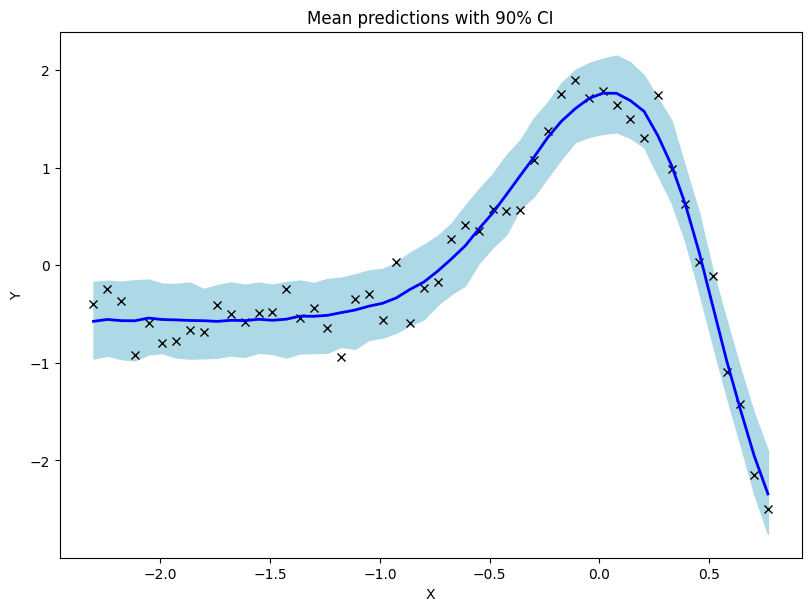

In [29]:
pred = m.sample(samples = 500)['Y']
pred = pred[..., 0]
mean_prediction = jnp.mean(pred, axis=0)
percentiles = np.percentile(pred, [5.0, 95.0], axis=0)
# make plots
fig, ax = plt.subplots(figsize=(8, 6), constrained_layout=True)
# plot training data
ax.plot(X[:, 1], Y[:, 0], "kx")
# plot 90% confidence level of predictions
ax.fill_between(
    X[:, 1], percentiles[0, :], percentiles[1, :], color="lightblue"
)
# plot mean prediction
ax.plot(X[:, 1], mean_prediction, "blue", ls="solid", lw=2.0)
ax.set(xlabel="X", ylabel="Y", title="Mean predictions with 90% CI")

[Text(0.5, 0, 'X'),
 Text(0, 0.5, 'Y'),
 Text(0.5, 1.0, 'Mean predictions with 90% CI')]

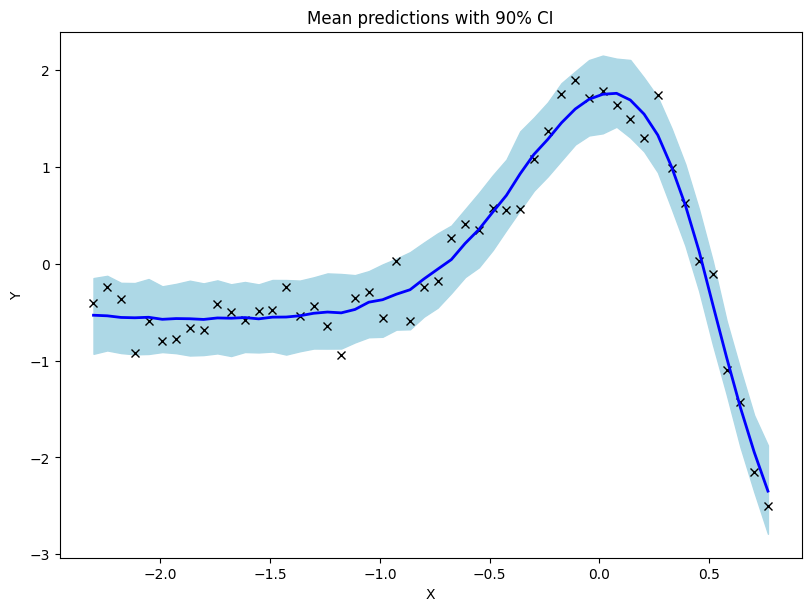

In [24]:
from numpyro import handlers
from jax import random, vmap
rng_key, rng_key_predict = random.split(random.PRNGKey(0))

def predict(model, rng_key, samples, X, D_H):
    model = handlers.substitute(handlers.seed(model, rng_key), samples)
    model_trace = handlers.trace(model).get_trace(X=X, Y=None, D_H=D_H)
    return model_trace["Y"]["value"]


samples=m.sampler.get_samples()
vmap_args = (
    samples,
    random.split(rng_key_predict, 500 * 1),
)

predictions = vmap(
    lambda samples, rng_key: predict(model, rng_key, samples, X, 1)
)(*vmap_args)

predictions = predictions[..., 0]
mean_prediction = jnp.mean(predictions, axis=0)
percentiles = np.percentile(predictions, [5.0, 95.0], axis=0)
# make plots
fig, ax = plt.subplots(figsize=(8, 6), constrained_layout=True)
# plot training data
ax.plot(X[:, 1], Y[:, 0], "kx")
# plot 90% confidence level of predictions
ax.fill_between(
    X[:, 1], percentiles[0, :], percentiles[1, :], color="lightblue"
)
# plot mean prediction
ax.plot(X[:, 1], mean_prediction, "blue", ls="solid", lw=2.0)
ax.set(xlabel="X", ylabel="Y", title="Mean predictions with 90% CI")


# Neural network for covariance matrix

## Simulated data

In [ ]:
import numpyro.distributions as dd
import pandas as pd

# setup platform------------------------------------------------
m = bi(platform='cpu')

a = 3.5  # average morning wait time
b = -1  # average difference afternoon wait time
sigma_a = 1  # std dev in intercepts
sigma_b = 0.5  # std dev in slopes
rho = -0.7  # correlation between intercepts and slopes
Mu = jnp.array([a, b])
cov_ab = sigma_a * sigma_b * rho
Sigma = jnp.array([[sigma_a**2, cov_ab], [cov_ab, sigma_b**2]])
jnp.array([1, 2, 3, 4]).reshape(2, 2).T
sigmas = jnp.array([sigma_a, sigma_b])  # standard deviations
Rho = jnp.array([[1, rho], [rho, 1]])  # correlation matrix
print("original Rho")
print(Rho)
# now matrix multiply to get covariance matrix
Sigma = jnp.diag(sigmas) @ Rho @ jnp.diag(sigmas)

N_cafes = 20
seed = random.PRNGKey(5)  # used to replicate example
vary_effects = m.dist.multivariatenormal(Mu, Sigma, shape=(N_cafes,), sample = True)
a_cafe = vary_effects[:, 0]
b_cafe = vary_effects[:, 1]

seed = random.PRNGKey(22)
N_visits = 10
afternoon = jnp.tile(jnp.arange(2), N_visits * N_cafes // 2)
cafe_id = jnp.repeat(jnp.arange(N_cafes), N_visits)
mu = a_cafe[cafe_id] + b_cafe[cafe_id] * afternoon
sigma = 0.5  # std dev within cafes
wait = m.dist.normal(mu, sigma, sample = True)
d = pd.DataFrame(dict(cafe=cafe_id, afternoon=afternoon, wait=wait))
#d.to_csv('../resources/data/Sim data multivariatenormal.csv', index=False)

jax.local_device_count 16
original Rho
[[ 1.  -0.7]
 [-0.7  1. ]]


## Covariance matrix using Cholesky decomposition

In [ ]:
# import data ------------------------------------------------
m = bi()
m.df = d

m.data_on_model = dict(
    cafe = jnp.array(m.df.cafe.values, dtype=jnp.int32),
    wait = jnp.array(m.df.wait.values, dtype=jnp.float32),
    N_cafes = len(m.df.cafe.unique()),
    afternoon = jnp.array(m.df.afternoon.values, dtype=jnp.float32)
)

def model(cafe, wait, N_cafes, afternoon):
    a = m.dist.normal(5, 2,  name = 'a')
    b = m.dist.normal(-1, 0.5, name = 'b')
    sigma = m.dist.exponential( 1,  name = 'sigma')

    sigma_cafe = m.dist.exponential(1, shape=(2,),  name = 'sigma_cafe')    
    Rho = m.dist.lkj(2, 2, name = 'Rho')
    cov = jnp.outer(sigma_cafe, sigma_cafe) * Rho
    a_cafe_b_cafe = m.dist.multivariatenormal(jnp.stack([a, b]), cov, shape = [N_cafes], name = 'a_b_cafe')    

    a_cafe, b_cafe = a_cafe_b_cafe[:, 0], a_cafe_b_cafe[:, 1]
    mu = a_cafe[cafe] + b_cafe[cafe] * afternoon
    m.dist.normal(mu, sigma, obs=wait)

# Run sampler ------------------------------------------------
m.fit(model) 



jax.local_device_count 16


sample: 100%|██████████| 1000/1000 [00:04<00:00, 208.27it/s, 15 steps of size 2.97e-01. acc. prob=0.90]


In [ ]:
# import data ------------------------------------------------
m2 = bi()
m2.df = d

m2.data_on_model = dict(
    cafe = jnp.array(m.df.cafe.values, dtype=jnp.int32),
    wait = jnp.array(m.df.wait.values, dtype=jnp.float32),
    N_cafes = len(m.df.cafe.unique()),
    afternoon = jnp.array(m.df.afternoon.values, dtype=jnp.float32)
)

def model(cafe, wait, N_cafes, afternoon):
    # Global parameters for intercept and slope
    a = m2.dist.normal(5, 2, name='a')
    b = m2.dist.normal(-1, 0.5, name='b')
    sigma = m2.dist.exponential(1, name='sigma')
    
    a_cafe_b_cafe = m.bnn.cov(10,N_cafes,a,b)
    
    # Split the network output into cafe-specific intercept and slope
    a_cafe, b_cafe = a_cafe_b_cafe[:, 0], a_cafe_b_cafe[:, 1]
    mu = a_cafe[cafe] + b_cafe[cafe] * afternoon
    
    m2.dist.normal(mu, sigma, obs=wait)

# Run sampler ------------------------------------------------
m2.run(model)


jax.local_device_count 16


sample: 100%|██████████| 1000/1000 [00:06<00:00, 162.23it/s, 127 steps of size 4.44e-02. acc. prob=0.90]


## Comparaison of covariance matrix with Choleslesky decomposition and with neural network

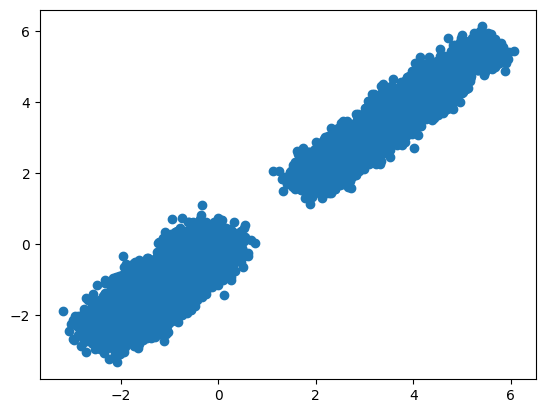

In [ ]:
plt.scatter(m.posteriors['a_b_cafe'],m2.posteriors['rf'])

## Recovering RHo of BNN

In [ ]:
m.bnn.get_rho(m2.posteriors['rf'])

Array([[ 1.        , -0.60165575],
       [-0.60165575,  1.        ]], dtype=float64)

In [ ]:
print("original Rho")
print(Rho)

original Rho
[[ 1.  -0.7]
 [-0.7  1. ]]
